In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from first_gm import SM_World, plot_SM, plot_raster, gaussian_kernel, tensor2spikeship

## Raster plot generative model with a superposition of SMs
### Parameters

In [3]:
class world_params:
    N_pre = 20 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be a odd number for convolutions)
    N_kernels = 5 # number of SM used for RP generation
    
    p_input = .1 # probability of having spike for the input
    SM_ratio = 10 # coefficient that gives the SM/noise spike ratio
    N_timesteps =  2**10 # number of timesteps in the RP
    
    p_spontaneous = p_input/(1+SM_ratio) # probability of the spontaneous activity
    
    # TODO define all this better to work only with probability values
    avg_N_spikes = N_delays*N_pre*p_spontaneous # average number of spikes per SM
    std_N_spikes = 1 # variance for the number of spikes per SM
    
    #p_sm = p_input*SM_ratio/(1+SM_ratio)
    p_output = p_input*SM_ratio/((1+SM_ratio)*avg_N_spikes)
    
    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision
    
    seed = 4815162342 # seed

TODO: change something in the formula with SM_ratio

### Generative model without motif overlapping

In [4]:
opt = world_params()
world = SM_World(opt)
input_rp, output_rp, input_rp_with_channels = world.draw_input(do_channels = True, sm_overlapping = False)

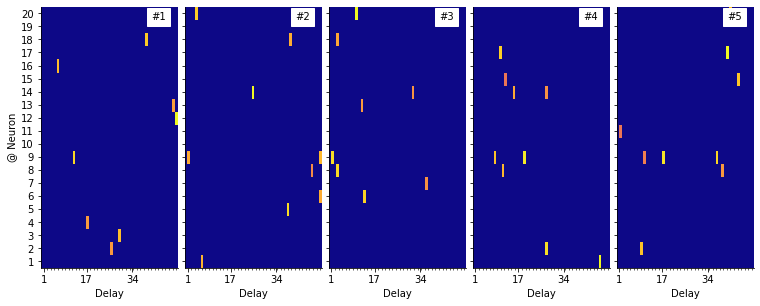

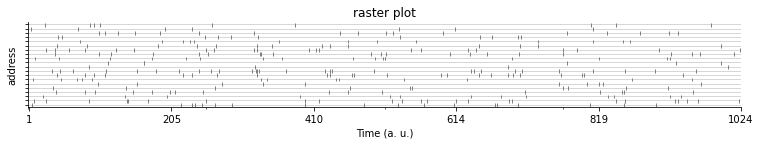

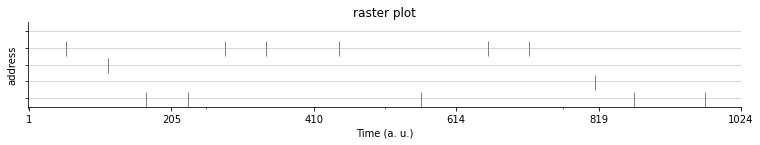

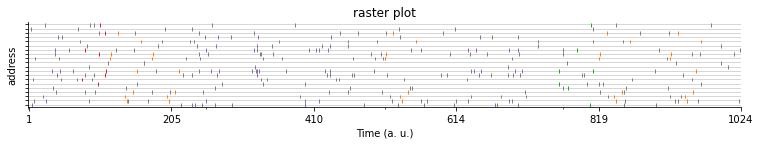

In [5]:
plot_SM(world.kernels, N_show = opt.N_kernels, figsize = (12, 5));
plot_raster(input_rp, colored=False);
plot_raster(output_rp, colored=False);
plot_raster(input_rp_with_channels, colored=True);

## Model with 2 motifs and a combination of the 2

In [6]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels 
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        if add_coef:
            self.opt.N_kernels = self.opt.N_kernels+1
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
        else:
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
            
        for k in range(self.opt.N_kernels):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            if self.kernels[k, :, :].max()>1: self.kernels[k, :,:]/=self.kernels[k, :, :].max()
        if add_coef:
            self.kernels[-1, :, :] = (1-add_coef)*self.kernels[0, :, :] + add_coef*self.kernels[1, :, :]
                
    def draw_input(self, N_trials = 1, do_channels = False, sm_overlapping = True):
        
        spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)
        
        if sm_overlapping:
            output_proba = torch.ones(N_trials, self.opt.N_kernels, self.opt.N_timesteps)*self.opt.p_output
            output_rp = torch.bernoulli(output_proba)
        else:
            N_output = int(self.opt.p_output*self.opt.N_kernels*self.opt.N_timesteps)
            output_rp = torch.zeros(N_trials, self.opt.N_kernels, self.opt.N_timesteps)
            for i in range(N_trials):
                address_output, time_output = torch.randint(self.opt.N_kernels, [N_output]), torch.randint(self.opt.N_delays, self.opt.N_timesteps, [N_output])
                sorted_ind = torch.argsort(time_output)
                time_output, address_output = time_output[sorted_ind], address_output[sorted_ind]
                ind = 0
                time_step = time_output[ind]
                while (time_step<self.opt.N_timesteps) & (ind<time_output.shape[0]):
                    time_step = time_output[ind]
                    non_overlapping_ind = np.where((time_output<=time_step) | (time_output>time_step+self.opt.N_delays))[0]
                    time_output, address_output = time_output[non_overlapping_ind], address_output[non_overlapping_ind]
                    ind += 1
                output_rp[i,address_output, time_output] = 1
        
        input_sm_proba = torch.conv_transpose1d(output_rp, self.kernels)
        input_sm_proba = torch.roll(input_sm_proba, -self.kernels.shape[2], dims=2)[:,:,:-self.kernels.shape[2]+1]
        
        input_rp = torch.bernoulli(torch.minimum(input_sm_proba, torch.ones_like(input_sm_proba))) + spontaneous_activity
        
        if do_channels:
            input_rp_with_channels = torch.zeros(self.opt.N_kernels+1, N_trials, self.opt.N_pre, self.opt.N_timesteps)
            input_rp_with_channels[0,:,:,:] = spontaneous_activity
            for sm in range(self.opt.N_kernels):
                output_rp_with_channels = torch.zeros(N_trials, self.opt.N_kernels, self.opt.N_timesteps)
                output_rp_with_channels[:,sm,:] = output_rp[:,sm,:]
                input_sm_proba_with_channels = torch.conv_transpose1d(output_rp_with_channels, self.kernels)
                input_sm_proba_with_channels = torch.roll(input_sm_proba_with_channels, -self.kernels.shape[2], dims=2)[:,:,:-self.kernels.shape[2]+1]
                input_rp_with_channels[sm+1,:,:,:] = torch.bernoulli(torch.minimum(input_sm_proba_with_channels, torch.ones_like(input_sm_proba_with_channels)))
        
            return input_rp, output_rp, input_rp_with_channels
        else:
            return input_rp, output_rp

In [7]:
opt = world_params()
opt.N_kernels = 2
world = SM_World(opt, add_coef = .2)
input_rp, output_rp, input_rp_with_channels = world.draw_input(do_channels = True, sm_overlapping = False)

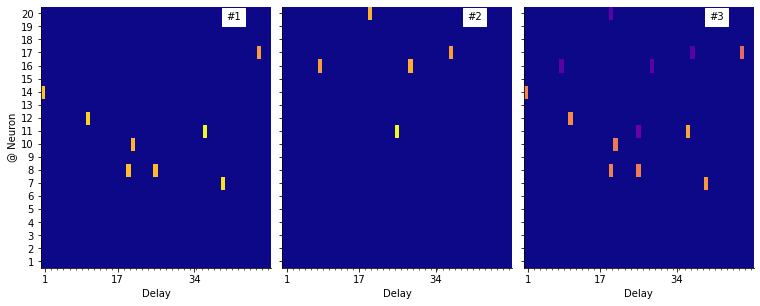

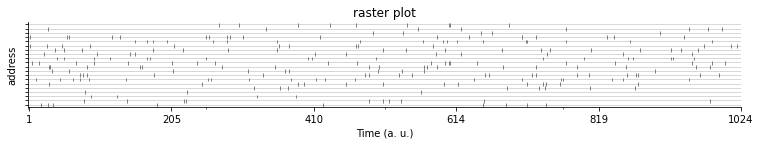

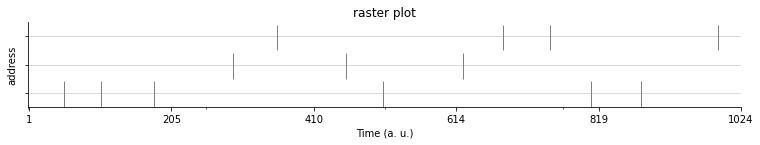

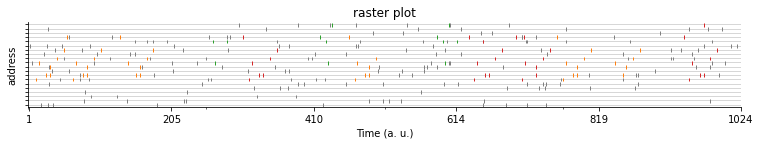

In [8]:
plot_SM(world.kernels, N_show = opt.N_kernels, figsize = (12, 5));
plot_raster(input_rp, colored=False);
plot_raster(output_rp, colored=False);
plot_raster(input_rp_with_channels, colored=True);

### Format the ouput for SpikeShip

In [9]:
spike_times, ii_spike_times = tensor2spikeship(input_rp)

### Multiple epochs (trials)

In [10]:
input_rp, output_rp = world.draw_input(N_trials = 10, sm_overlapping = False)
spike_times, ii_spike_times = tensor2spikeship(input_rp)
ii_spike_times.shape

(10, 20, 2)

In [11]:
print(ii_spike_times)

[[[   0.    6.]
  [   6.   15.]
  [  15.   26.]
  [  26.   37.]
  [  37.   45.]
  [  45.   59.]
  [  59.   72.]
  [  72.   87.]
  [  87.   97.]
  [  97.  113.]
  [ 113.  130.]
  [ 130.  142.]
  [ 142.  155.]
  [ 155.  174.]
  [ 174.  186.]
  [ 186.  203.]
  [ 203.  221.]
  [ 221.  227.]
  [ 227.  234.]
  [ 234.  249.]]

 [[ 249.  258.]
  [ 258.  264.]
  [ 264.  276.]
  [ 276.  286.]
  [ 286.  296.]
  [ 296.  302.]
  [ 302.  318.]
  [ 318.  348.]
  [ 348.  356.]
  [ 356.  376.]
  [ 376.  397.]
  [ 397.  416.]
  [ 416.  428.]
  [ 428.  443.]
  [ 443.  449.]
  [ 449.  464.]
  [ 464.  485.]
  [ 485.  491.]
  [ 491.  503.]
  [ 503.  512.]]

 [[ 512.  523.]
  [ 523.  532.]
  [ 532.  542.]
  [ 542.  552.]
  [ 552.  559.]
  [ 559.  568.]
  [ 568.  589.]
  [ 589.  608.]
  [ 608.  617.]
  [ 617.  631.]
  [ 631.  649.]
  [ 649.  669.]
  [ 669.  685.]
  [ 685.  699.]
  [ 699.  712.]
  [ 712.  724.]
  [ 724.  741.]
  [ 741.  749.]
  [ 749.  757.]
  [ 757.  771.]]

 [[ 771.  786.]
  [ 786.  789.]
  

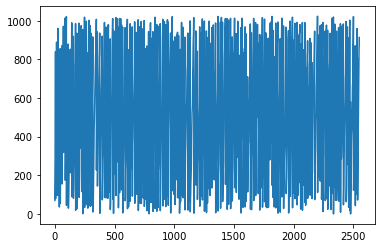

In [12]:
import matplotlib.pyplot as plt
plt.plot(spike_times)